In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy.stats import beta  # función de densidad Beta de SciPy
seed=1710

In [4]:
from modelo import CotizacionHistorica
from datetime import date
historico = CotizacionHistorica("data/aapl_5y.csv")
df_prior = historico.cotizaciones(historico.fecha_min(), date(2024, 6, 12))
df = historico.cotizaciones(date(2024, 6, 13), date(2025, 6, 12))

In [9]:
n_observaciones=len(df)
prior_mean = df_prior["Diff_Apertura_Cierre"].mean()
prior_sd = df_prior["Diff_Apertura_Cierre"].std()
data_sd = df["Diff_Apertura_Cierre"].std()
print(prior_mean, prior_sd)
print("sd verosimilitud", data_sd)

-0.12120427435387643 2.236975207830738
sd verosimilitud 3.5593244740628314


In [11]:
with pm.Model() as model4:
    # a priori
    mu = pm.Normal("mu", mu=prior_mean, sigma=prior_sd)
    # Verosimilitud como Normal, usando el sigma del problema
    y = pm.Normal("y", mu=mu, sigma=data_sd, observed=df["Diff_Apertura_Cierre"])
    # Muestreo del Posterior
    idata4 = pm.sample(chains=4, random_seed=seed)
    # Agregar el prior a idata4 (Necesario para calcular el Factor de Bayes)
    idata4.extend(pm.sample_prior_predictive(8000, random_seed=seed))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/home/nadia/dev/unsl-bayes-stock/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [mu, y]


array([[<Axes: title={'center': 'mu'}>,
        <Axes: title={'center': 'mu'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

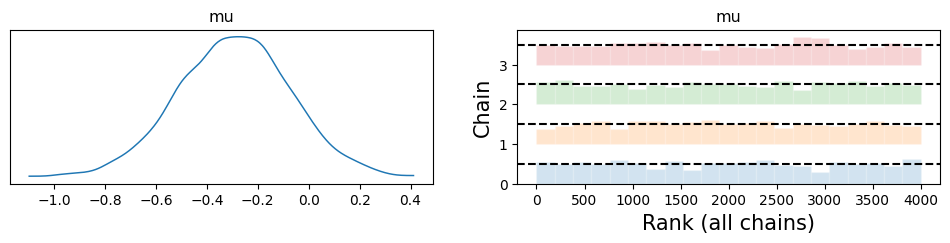

In [12]:
az.plot_trace(idata4, kind="rank_bars", combined=True)

In [13]:
az.summary(idata4, hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.29,0.22,-0.72,0.15,0.01,0.0,1840.71,2763.9,1.0


In [14]:
idata4.posterior["mu"].var().values

array(0.04853151)

In [15]:
posterior_mu = idata4.posterior["mu"].values.flatten()

# Definir el valor bajo la hipótesis nula (el límite)
h0_value = 0
prob_mu_less_than_h0 = np.mean(posterior_mu < h0_value)

print(f"Probabilidad posterior de que mu < {h0_value}: {prob_mu_less_than_h0:.4f}")

Probabilidad posterior de que mu < 0: 0.9093


In [17]:
# Extraer las muestras del prior de mu
prior_mu = idata4.prior["mu"].values.flatten()
# Calcular la probabilidad prior de que mu sea menor que h0_value
prob_mu_less_than_h1 = np.mean(prior_mu < h0_value)
print(f"Probabilidad prior de que mu < {h0_value}: {prob_mu_less_than_h1:.4f}")

Probabilidad prior de que mu < 0: 0.5236


In [18]:
bf10 = prob_mu_less_than_h0 / prob_mu_less_than_h1
print(f"Factor de Bayes (BF10): {bf10:.4f}")

Factor de Bayes (BF10): 1.7365


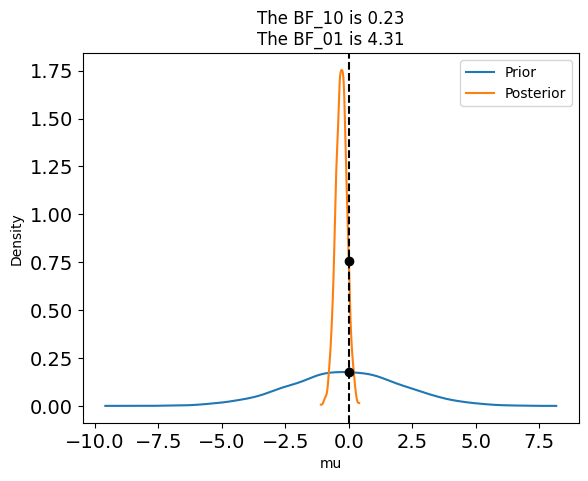

In [23]:
bf_dict, ax = az.plot_bf(idata4, var_name="mu", ref_val=0);

<Axes: title={'center': 'mu'}>

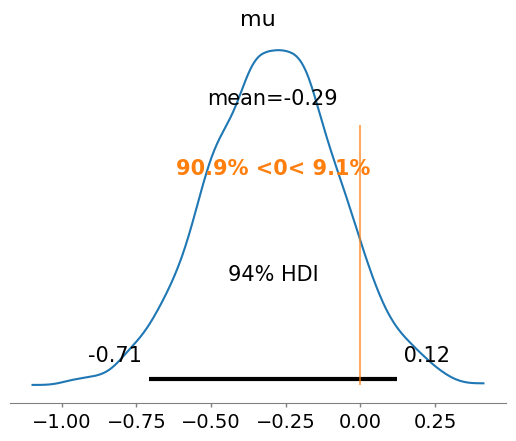

In [22]:
az.plot_posterior(idata4, var_names=['mu'], ref_val=0)

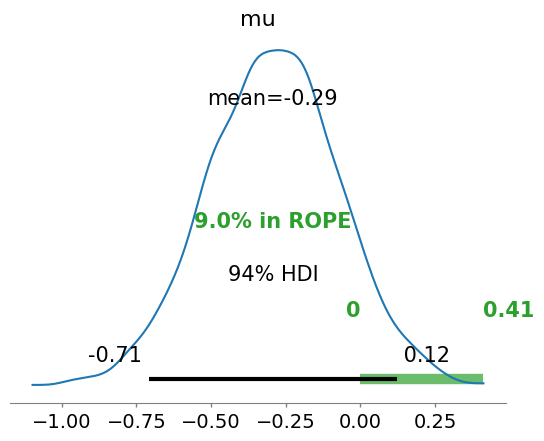

In [21]:
# Graficamos la distribución posterior de mu, marcando la región de probabilidad de H0
# rope : tiene los valores inferior y superior de la Región de Equivalencia Práctica (Region Of Practical Equivalence)
max_rope = idata4.posterior["mu"].values.max().round(2)# Establecemos un máximo para ROPE según el posterior
prob_h0_az = az.plot_posterior(idata4, var_names=['mu'], rope=[0, max_rope])